<h2>Formula 1 Grand Prix status prediction</h2>

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV,train_test_split,KFold,GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle


plt.style.use('bmh')
pd.set_option('display.float_format', '{:.2f}'.format)

<h3>Data cleaning</h3>

In [75]:
results = pd.read_csv(r'data/results.csv')
races = pd.read_csv(r'data/races.csv')
qualifyings = pd.read_csv(r'data/qualifying.csv')
drivers = pd.read_csv(r'data/drivers.csv')
constructors = pd.read_csv(r'data/constructors.csv')
circuits = pd.read_csv(r'data/circuits.csv')
status = pd.read_csv(r'data/status.csv')
laptimes = pd.read_csv(r'data/lap_times.csv')


countries = pd.read_csv(r'data/countries/countries.csv')

In [76]:
df1 = pd.merge(races,results,how='left',on=['raceId'], suffixes=('_race', '_result'))
#f2 = pd.merge(df1,qualifyings,how='left',on=['raceId','driverId','constructorId'], suffixes=('', '_qualifying'))
df3 = pd.merge(df1,drivers,how='left',on=['driverId'], suffixes=('', '_driver'))
df4 = pd.merge(df3,constructors,how='left',on=['constructorId'], suffixes=('', '_constructor'))
df5 = pd.merge(df4,circuits,how='left',on=['circuitId'], suffixes=('', '_circuit'))
df6 = pd.merge(df5,status,how='left',on=['statusId'], suffixes=('', '_status'))
df7 = pd.merge(df6,laptimes,how='left',on=['raceId','driverId'], suffixes=('', '_laptime'))

In [77]:

data = df7;
#drop the columns which are not important


data = data.drop(['raceId',  'round', 'circuitId', 'name', 'time_race',
       'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'constructorId', 'number',  'position',
       'positionText','positionOrder', 'points', 'time_result',
        'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId',  'driverRef', 'number_driver',
       'code',   'url_driver',
       'constructorRef', 
       'url_constructor', 'circuitRef',  'location',
       'lat', 'lng', 'alt', 'url_circuit', 'lap', 'position_laptime','time'
      ],axis=1)

In [78]:
testData = data.copy()
#print test data where year = 2020 and name_circuit = 'Bahrain International Circuit'
testData
#export test data to csv
#testData.to_csv('testData.csv', index=False)


,year,date,weather,driverId,grid,laps,milliseconds,forename,surname,dob,nationality,name_constructor,nationality_constructor,name_circuit,country,type,status,milliseconds_laptime
0,1950,13-05-50,NaN,642,1,70,8003600,Nino,Farina,1906-10-30,Italian,Alfa Romeo,Swiss,Silverstone Circuit,UK,Race circuit,Finished,NaN
1,1950,13-05-50,NaN,786,2,70,8006200,Luigi,Fagioli,1898-06-09,Italian,Alfa Romeo,Swiss,Silverstone Circuit,UK,Race circuit,Finished,NaN
2,1950,13-05-50,NaN,686,4,70,8055600,Reg,Parnell,1911-07-02,British,Alfa Romeo,Swiss,Silverstone Circuit,UK,Race circuit,Finished,NaN
3,1950,13-05-50,NaN,704,6,68,\N,Yves,Cabantous,1904-10-08,French,Talbot-Lago,French,Silverstone Circuit,UK,Race circuit,+2 Laps,NaN
4,1950,13-05-50,NaN,627,9,68,\N,Louis,Rosier,1905-11-05,French,Talbot-Lago,French,Silverstone Circuit,UK,Race circuit,+2 Laps,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604794,2024,08-12-24,Night,861,20,26,\N,Franco,Colapinto,2003-05-27,Argentinian,Williams,British,Yas Marina Circuit,UAE,Race circuit,Engine,90387.00
604795,2024,08-12-24,Night,861,20,26,\N,Franco,Colapinto,2003-05-27,Argentinian,Williams,British,Yas Marina Circuit,UAE,Race circuit,Engine,90528.00
604796,2024,08-12-24,Night,861,20,26,\N,Franco,Colapinto,2003-05-27,Argentinian,Williams,British,Yas Marina Circuit,UAE,Race circuit,Engine,90254.00
604797,2024,08-12-24,Night,861,20,26,\N,Franco,Colapinto,2003-05-27,Argentinian,Williams,British,Yas Marina Circuit,UAE,Race circuit,Engine,100514.00


In [79]:
#rename the columns
data.rename(columns={'name':'race_name','grid':'qualification_pos','name_constructor':'constructor',
                     'nationality':'driver_nationality','nationality_constructor':'constructor_nationality', 'name_circuit' :'circuit', 'country': 'country_circuit', 'type': 'type_circuit', 'dob':'driver_date_of_birth'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
#drop forename columns and surname columns
data = data.drop(['forename','surname'],axis=1)
def convert_to_full_date(date_str):
    day, month, year = date_str.split('-')
    year = int(year)
    # Assume years < 50 are in 2000s, otherwise in 1900s
    full_year = 2000 + year if year < 50 else 1900 + year
    return f"{day}-{month}-{full_year}"
# Specify the date format explicitly
data['full_date'] = data['date'].apply(convert_to_full_date)
data['driver_date_of_birth'] = pd.to_datetime(data['driver_date_of_birth'])
data['date'] = pd.to_datetime(data['full_date'], format='%d-%m-%Y')
data = data.drop(['full_date'],axis=1)




In [80]:
data['age_at_gp_in_days'] = abs(data['driver_date_of_birth']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0]).astype(int)

first_race_dates = data.groupby('driverId')['date'].min().reset_index()
first_race_dates.rename(columns={'date': 'first_race_date'}, inplace=True)
data = data.merge(first_race_dates, on='driverId', how='left')
data = data.drop(['driverId'],axis=1)

data['days_since_first_race'] = abs(data['first_race_date']-data['date'])
data['days_since_first_race'] = data['days_since_first_race'].apply(lambda x: str(x).split(' ')[0]).astype(int)

In [81]:
#create a rain column where if the weather is 'Rain or 'Changeable' or 'Very changeable' then 1 else 0
data['rain'] = data['weather'].apply(lambda x: 1 if x in ['Rain', 'Changeable', 'Very changeable'] else 0)
#drop the weather column
data = data.drop(['weather'],axis=1)

In [82]:
#select all data from 1980
data = data[data['year']>=1980]
#get first nationality only


In [83]:
print(data.columns)

Index(['year', 'date', 'qualification_pos', 'laps', 'milliseconds',
       'driver_date_of_birth', 'driver_nationality', 'constructor',
       'constructor_nationality', 'circuit', 'country_circuit', 'type_circuit',
       'status', 'milliseconds_laptime', 'driver', 'age_at_gp_in_days',
       'first_race_date', 'days_since_first_race', 'rain'],
      dtype='object')


In [84]:
#get all unique constructors
constructors = data['constructor'].unique()
print('All Constructors:')
print(constructors)

All Constructors:
['Williams' 'Brabham' 'Fittipaldi' 'Tyrrell' 'Alfa Romeo' 'McLaren'
 'Ferrari' 'Ensign' 'Ligier' 'Arrows' 'ATS' 'Team Lotus' 'Renault'
 'Shadow' 'Osella' 'Theodore' 'March' 'Toleman' 'RAM' 'Spirit' 'Minardi'
 'Zakspeed' 'Lola' 'Benetton' 'AGS' 'Larrousse' 'Coloni' 'Rial'
 'Euro Brun' 'Dallara' 'Onyx' 'Leyton House' 'Life' 'Lambo' 'Jordan'
 'Footwork' 'Fondmetal' 'Andrea Moda' 'Sauber' 'Simtek' 'Pacific' 'Forti'
 'Prost' 'Stewart' 'BAR' 'Jaguar' 'Toyota' 'Red Bull' 'Honda' 'Toro Rosso'
 'BMW Sauber' 'MF1' 'Super Aguri' 'Spyker MF1' 'Spyker' 'Force India'
 'Brawn' 'Mercedes' 'Lotus' 'HRT' 'Virgin' 'Lotus F1' 'Marussia'
 'Caterham' 'Manor Marussia' 'Haas F1 Team' 'Racing Point' 'AlphaTauri'
 'Aston Martin' 'Alpine F1 Team' 'RB F1 Team']


In [85]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Aston Martin' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='BMW Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Alpine F1 Team' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='RB F1 Team' else x)

In [86]:
data['constructor_nationality'].unique()


array(['British', 'Brazilian', 'Swiss', 'Italian', 'French', 'Hong Kong',
       'German', 'Irish', 'Japanese', 'Austrian', 'Russian', 'Dutch',
       'Indian', 'Malaysian', 'Spanish', 'American'], dtype=object)

In [87]:
#clean data
data['driver_nationality'] = data['driver_nationality'].replace('Argentinian', 'Argentine')
data['country_circuit'] = data['country_circuit'].replace('United States', 'USA')

In [88]:
#for country circuit

#Change all "Argentinian" to "Argentine"
data_tmp = data.copy()

#get first nationality only
df_countries = countries.copy()
df_countries['nationality'] = df_countries['nationality'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UK' if x=='United Kingdom of Great Britain and Northern Ireland' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UAE' if x=='United Arab Emirates' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Korea' if x=='Korea (Republic of)' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Russia' if x=='Russian Federation' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'USA' if x=='United States of America' else x)

#drop rows with duplicate nationality
df_countries = df_countries[df_countries['en_short_name'] != 'Taiwan']
df_countries = df_countries[df_countries['en_short_name'] != 'United States Minor Outlying Islands']


data_with_circuit_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='country_circuit', 
    right_on='en_short_name'  
)

#en_short_name

data_with_circuit_nationality=data_with_circuit_nationality.drop(['country_circuit', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_circuit_nationality.rename(columns={'alpha_3_code':'circuit_nationality'}, inplace=True)


In [89]:
data_tmp = data_with_circuit_nationality.copy()

data_with_driver_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='driver_nationality', 
    right_on='nationality'  
)

data_with_driver_nationality=data_with_driver_nationality.drop(['driver_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_driver_nationality.rename(columns={'alpha_3_code':'driver_nationality'}, inplace=True)



In [90]:
data_tmp = data_with_driver_nationality.copy()

data_with_constructor_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='constructor_nationality', 
    right_on='nationality'  
)
data_with_constructor_nationality=data_with_constructor_nationality.drop(['constructor_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_constructor_nationality.rename(columns={'alpha_3_code':'constructor_nationality'}, inplace=True)


In [91]:
#data after processing nationalities
data = data_with_constructor_nationality;
data['driver_home'] = data['driver_nationality'] == data['circuit_nationality']
data['constructor_home'] = data['constructor_nationality'] == data['circuit_nationality']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))


In [92]:
#create a dnf column
# pattern = r"\+.* Lap.*"
# data_median = data_median[data_median['status'].eq('Finished') | data_median['status'].str.match(pattern)]
#dnf = 0 if status = 'Finished' or match regex else 1
pattern = r"\+.* Lap.*"
data['dnf'] = data['status'].apply(lambda x: 0 if x == 'Finished' or re.match(pattern, x) else 1)
data.drop(['status'], axis=1, inplace=True)
data.drop_duplicates(inplace=True)
data


,year,date,qualification_pos,laps,milliseconds,driver_date_of_birth,constructor,circuit,type_circuit,milliseconds_laptime,...,age_at_gp_in_days,first_race_date,days_since_first_race,rain,circuit_nationality,driver_nationality,constructor_nationality,driver_home,constructor_home,dnf
0,1980,1980-01-13,1,53,6204380,1946-11-02,Williams,Autódromo Juan y Oscar Gálvez,Race circuit,NaN,...,12125,1975-04-27,1722,0,ARG,AUS,GBR,0,0,0
1,1980,1980-01-13,4,53,6228970,1952-08-17,Brabham,Autódromo Juan y Oscar Gálvez,Race circuit,NaN,...,10010,1978-07-30,532,0,ARG,BRA,GBR,0,0,0
2,1980,1980-01-13,13,53,6283020,1948-12-06,Fittipaldi,Autódromo Juan y Oscar Gálvez,Race circuit,NaN,...,11360,1978-03-04,680,0,ARG,FIN,BRA,0,0,0
3,1980,1980-01-13,22,53,6287860,1953-03-11,Tyrrell,Autódromo Juan y Oscar Gálvez,Race circuit,NaN,...,9804,1978-04-02,651,0,ARG,IRL,GBR,0,0,0
4,1980,1980-01-13,20,52,\N,1952-09-10,Alfa Romeo,Autódromo Juan y Oscar Gálvez,Race circuit,NaN,...,9986,1977-09-11,854,0,ARG,ITA,CHE,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596867,2024,2024-12-08,20,26,\N,2003-05-27,Williams,Yas Marina Circuit,Race circuit,90387.00,...,7866,2024-09-01,98,0,ARE,ARG,GBR,0,0,1
596868,2024,2024-12-08,20,26,\N,2003-05-27,Williams,Yas Marina Circuit,Race circuit,90528.00,...,7866,2024-09-01,98,0,ARE,ARG,GBR,0,0,1
596869,2024,2024-12-08,20,26,\N,2003-05-27,Williams,Yas Marina Circuit,Race circuit,90254.00,...,7866,2024-09-01,98,0,ARE,ARG,GBR,0,0,1
596870,2024,2024-12-08,20,26,\N,2003-05-27,Williams,Yas Marina Circuit,Race circuit,100514.00,...,7866,2024-09-01,98,0,ARE,ARG,GBR,0,0,1


<h3>Testing different models on cleaned data</h3>

In [93]:
# Drop irrelevant columns
columns_to_drop = [ 'driver_date_of_birth', 'date', 'first_race_date',
                   'milliseconds', 'milliseconds_laptime', 'laps']


cleaned_data = data.drop(columns=columns_to_drop)
cleaned_data.rename(columns={'qualification_pos':'qualification_position'},inplace=True)
cleaned_data.drop_duplicates(inplace=True)
cleaned_data.dtypes
#export cleaned data to csv
cleaned_data.to_csv('cleaned_status_data.csv', index=False)

In [94]:
# Split features and target
y = cleaned_data['dnf']
X = cleaned_data.drop(columns=['dnf'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [98]:
#print data where eyar = 2020 and name_circuit = 'Bahrain International Circuit'
X_train


,year,qualification_position,constructor,circuit,type_circuit,driver,age_at_gp_in_days,days_since_first_race,rain,circuit_nationality,driver_nationality,constructor_nationality,driver_home,constructor_home
331062,2013,13,Racing Point,Circuit de Barcelona-Catalunya,Race circuit,Adrian Sutil,11079,2247,0,ESP,DEU,IND,0,0
1664,1983,0,Williams,Autodromo Nazionale di Monza,Race circuit,Jacques Laffite,14539,3325,0,ITA,FRA,GBR,0,0
252844,2009,10,Renault,Autódromo José Carlos Pace,Race circuit,Fernando Alonso,10308,3150,0,BRA,ESP,FRA,0,0
203464,2007,12,AlphaTauri,Circuit de Monaco,Street circuit,Vitantonio Liuzzi,9790,763,0,MCO,ITA,ITA,0,0
362626,2014,8,Red Bull,Autodromo Nazionale di Monza,Race circuit,Sebastian Vettel,9928,2639,0,ITA,DEU,AUT,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196076,2006,20,Super Aguri,Suzuka Circuit,Race circuit,Takuma Sato,10845,1680,0,JPN,JPN,JPN,1,1
231678,2008,14,Ferrari,Autodromo Nazionale di Monza,Race circuit,Kimi Räikkönen,10560,2751,1,ITA,FIN,ITA,0,1
5390,1991,13,Brabham,Circuit de Spa-Francorchamps,Race circuit,Mark Blundell,9270,168,0,BEL,GBR,GBR,0,0
860,1982,0,Arrows,Kyalami,Race circuit,Brian Henton,12910,2380,0,ZAF,GBR,GBR,0,0


<h3> Random forest classifier</h3>

In [99]:
# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid
param_grid = {
    # 'model__max_depth': [30],
    # 'model__min_samples_leaf': [2, 3, 4],
    # 'model__min_samples_split': [10, 15],
    # 'model__n_estimators': [600, 800]
    
    'model__max_depth': [30],
    'model__min_samples_leaf': [4],
    'model__min_samples_split': [15],
    'model__n_estimators': [800]
}

# Cross-validation strategy
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Grid search with classification scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc', 
    verbose=1,
    n_jobs=-1
)

# Train model
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC AUC Score (CV): {grid_search.best_score_:.4f}")

# Final model
best_model_rf = grid_search.best_estimator_

# Predict on test set
y_pred = best_model_rf.predict(X_test)
y_proba = best_model_rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 800}
Best ROC AUC Score (CV): 0.7623

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2282
           1       0.68      0.52      0.59      1485

    accuracy                           0.71      3767
   macro avg       0.70      0.68      0.68      3767
weighted avg       0.71      0.71      0.70      3767

Confusion Matrix:
[[1918  364]
 [ 719  766]]
ROC AUC Score: 0.7657


C:\Users\Admin\AppData\Local\Temp\ipykernel_10816\1344995424.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


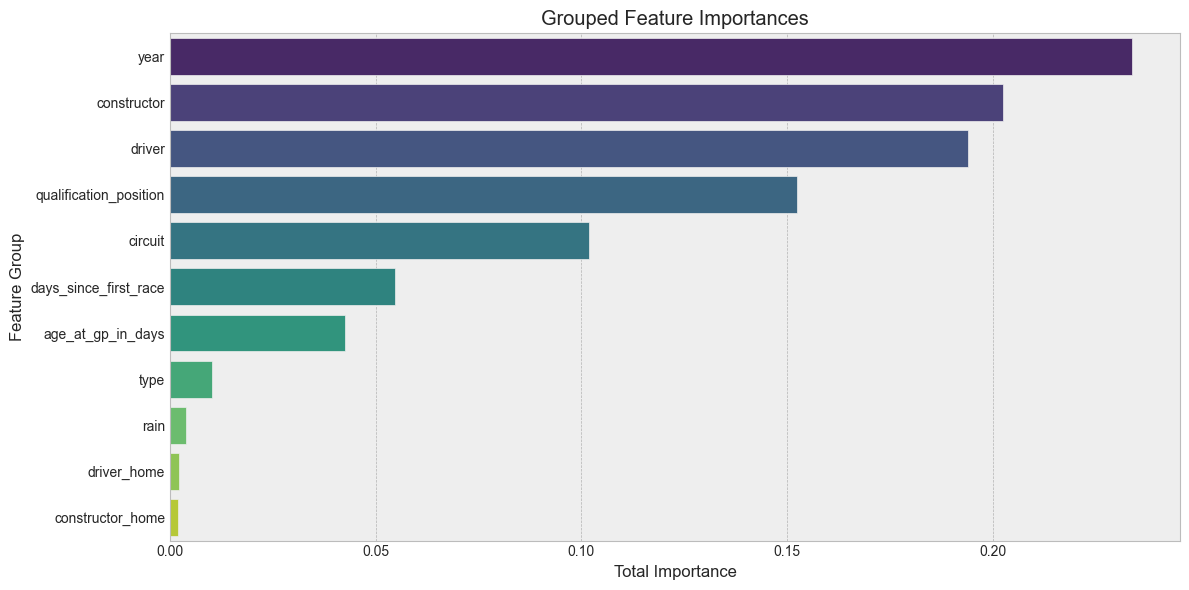

In [100]:
# Get best pipeline from grid search
best_pipeline = best_model_rf

# Get preprocessor and trained model
preprocessor = best_pipeline.named_steps['preprocessing']
model = best_pipeline.named_steps['model']

# Extract feature names after preprocessing
# 1. Numeric feature names (not transformed)
num_features = num_cols

# 2. Categorical one-hot encoded feature names
ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)

# 3. Combine both
feature_names = np.concatenate([num_features, cat_features])

# 4. Extract feature importances from the model
importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [46]:
# save
with open('rf_status.pkl','wb') as f:
    pickle.dump(best_model_rf,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)


<h5>Gradient boost regressor</h5>

In [ ]:
# Split features and target

# Identify column types
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# Preprocessor: OHE for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor())
])

# GridSearchCV parameters (nested under "model__")
param_grid = {
    'model__loss': [ 'huber'],
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [ 300, 400],
    'model__min_samples_split': [ 5, 10, 15],
    'model__min_samples_leaf': [ 4, 5],
    'model__max_depth': [ 4, 5],
}

# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)


# Best model and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_gb = grid_search.best_estimator_
y_pred = best_model_gb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")



Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Admin\AppData\Local\Temp\ipykernel_28920\1985290073.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


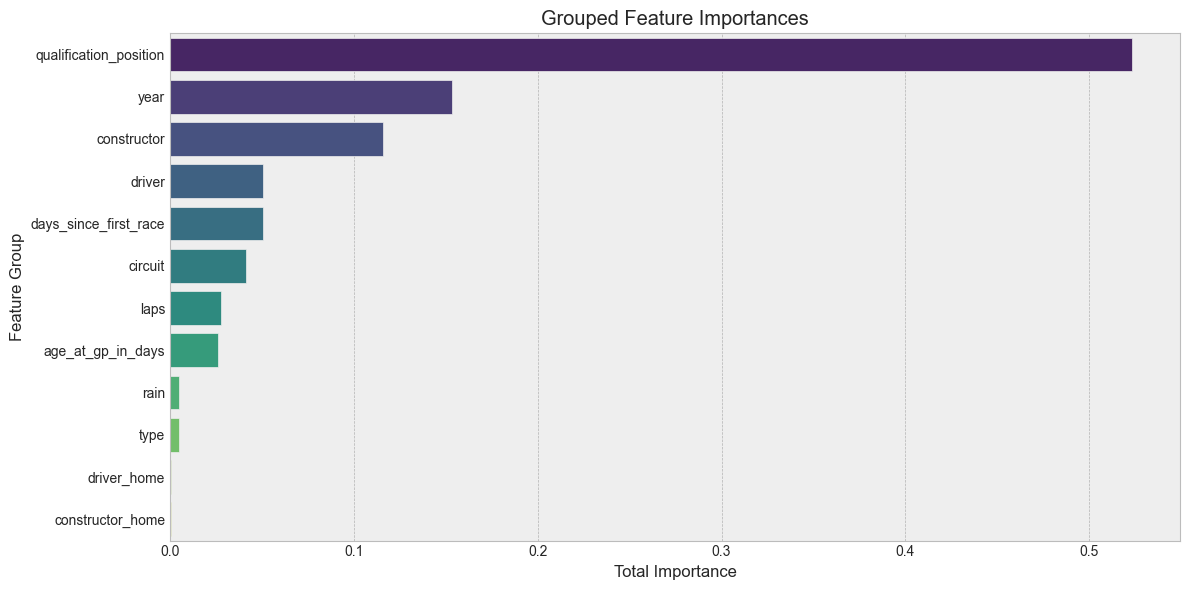

In [48]:
# Get best pipeline from grid search
best_pipeline = best_model_gb

# Get preprocessor and trained model
preprocessor = best_pipeline.named_steps['preprocessing']
model = best_pipeline.named_steps['model']

# Extract feature names after preprocessing
# 1. Numeric feature names (not transformed)
num_features = num_cols

# 2. Categorical one-hot encoded feature names
ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)

# 3. Combine both
feature_names = np.concatenate([num_features, cat_features])

# 4. Extract feature importances from the model
importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [49]:
# save
with open('gb.pkl','wb') as f:
    pickle.dump(best_model_gb,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

<h5>Neural network</h5>

In [43]:

# Identify column types
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# Preprocessor: OHE for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', MLPRegressor(random_state=42, hidden_layer_sizes=(100, 100, 100, 100, 100), activation='relu', alpha=0.0001, learning_rate_init=0.001, solver='adam',max_iter=500 , verbose=1))
])

param_grid = {
    'model__hidden_layer_sizes': [ (50, 50), (100, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01],
    'model__solver': ['adam'],
}
# Cross-validation
# k = 5
# cv = KFold(n_splits=k, shuffle=True, random_state=42)
# 
# grid_search = GridSearchCV(estimator=pipeline,
#                            param_grid=param_grid,
#                            cv=cv,
#                            scoring='neg_mean_squared_error',
#                            verbose=1,
#                            n_jobs=-1)

# grid_search.fit(X, y)



# print("Best Parameters:", grid_search.best_params_)
# best_rmse = np.sqrt(-grid_search.best_score_)
# print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

# best_model_nn = grid_search.best_estimator_
best_model_nn = pipeline.fit(X_train, y_train)
y_pred = best_model_nn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Iteration 1, loss = 19505293932.26761627
Iteration 2, loss = 19339624687.98759079
Iteration 3, loss = 17605962386.54886246
Iteration 4, loss = 16294231027.35140038
Iteration 5, loss = 15672856111.43644714
Iteration 6, loss = 15270910663.63723946
Iteration 7, loss = 15012347627.59606552
Iteration 8, loss = 14737438137.89470863
Iteration 9, loss = 14569363758.10036469
Iteration 10, loss = 14367179856.93494225
Iteration 11, loss = 14271270828.76671028
Iteration 12, loss = 14143581782.23073387
Iteration 13, loss = 13948901736.04241371
Iteration 14, loss = 13861729082.59055138
Iteration 15, loss = 13720660324.46716118
Iteration 16, loss = 13567790375.13724899
Iteration 17, loss = 13511319122.12802505
Iteration 18, loss = 13422499544.94511414
Iteration 19, loss = 13271295255.94198036
Iteration 20, loss = 13122576954.61436844
Iteration 21, loss = 12988546843.68262863
Iteration 22, loss = 12888461906.48037720
Iteration 23, loss = 12755432813.32407188
Iteration 24, loss = 12679679182.21057320
I

In [50]:
# best_model_nn = grid_search.best_estimator_
best_model_nn = pipeline.fit(X_train, y_train)
y_pred = best_model_nn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Final Model Performance:
MSE: 13042728856.10
RMSE: 114204.77
R2: 0.4811
MAE: 51377.28


In [36]:
# save
with open('nn.pkl','wb') as f:
    pickle.dump(best_model_nn,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)